In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal as sig
from wettbewerb import load_references
import CNN_dataset

In [ ]:
training_folder = "../shared_data/training_mini"
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder)

In [ ]:
CNN_dataset.create_cnn_dataset_map(ids, channels, data, sampling_frequencies, reference_systems, eeg_labels)

In [ ]:
import torch 

dataset = torch.load("cnn_map_dataset.pt")
x, y = dataset[12]

print("Label:", y.item() if torch.is_tensor(y) else y)
print("Input shape:", x.shape)
print("Feature map:\n", x[0])

In [ ]:
import random
import torch
import os
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
dataset_path = "cnn_map_dataset.pt"
if not os.path.exists(dataset_path):
    raise FileNotFoundError("Run CNN_dataset.py, um Dataset zu erstellen")
    
dataset = torch.load(dataset_path)
print("Dataset geladen")
labels = [int(tens[1].item()) for tens in dataset]
print("Label distribution:", Counter(labels))

# durch Fensterung kommt es zu viel mehr negativen Samples
positive = [g for g in dataset if g[1].item() == 1]
negative = [g for g in dataset if g[1].item() == 0]

# Gleich viele negative wie positive behalten
negative = random.sample(negative, len(positive))
print(f"postiv {len(positive)}, negative {len(negative)}")
balanced_data = positive + negative
random.shuffle(balanced_data)

# Train Test split the Data 
train_size = int(0.8 * len(balanced_data))
test_size = len(balanced_data) - train_size
torch.manual_seed(42)
train_dataset, test_dataset = random_split(balanced_data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size =32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size =32, shuffle = False)


import CNN_model

model = CNN_model.CNN_EEG(in_channels=9, n_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = CNN_model.train_model(model, train_loader, optimizer, loss_fn)
    test_acc, _, _ = CNN_model.evaluate_model(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    
torch.save(model, "small_trained_cnn_weights.pth")


plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
import random
import importlib
import torch
import os
from torch.utils.data import random_split, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import torch.nn as nn 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import csv
import numpy as np
# Datenordner einladen:
data_folder = "data_long"  
file_paths = sorted(glob(os.path.join(data_folder, "*.pt")))

if not os.path.exists(data_folder):
    raise FileNotFoundError("Unterordner nicht gefunden")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Modell instantiieren
import CNN_model
importlib.reload(CNN_model)
model = CNN_model.CNN_EEG(in_channels=9, n_classes=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
train_losses = []
train_accuracies = []
test_accuracies = []
batch_nr = 0
train_dataset_global = []
test_dataset_global =[]
for file_path in file_paths:
    
    print(f"Lade Dataset {batch_nr}")
    dataset = torch.load(file_path)
    print(f"Dataset {batch_nr} geladen")
    
    random.shuffle(dataset)

    # Train Test split the Data 
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    torch.manual_seed(42)
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    test_dataset_global.append(test_dataset)
    train_dataset_global.append(train_dataset)
    
    batch_nr = batch_nr +1
    

train_dataset_global = ConcatDataset(train_dataset_global)
test_dataset_global = ConcatDataset(test_dataset_global)
train_loader = DataLoader(train_dataset_global, batch_size =32, shuffle = True)
test_loader = DataLoader(test_dataset_global, batch_size =32, shuffle = False)

# Dynamische Gewichtung der Klassen
all_labels = [label.item() for _, label in train_dataset_global]
label_counts = Counter(all_labels)
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

weights = [total_samples / (num_classes * label_counts[i]) for i in range(num_classes)]
weights[1] *= 3.0
weights = torch.tensor(weights, dtype=torch.float32).to(device)

print(f"Klassenverteilung: {label_counts}")
print(f"Dynamische Verlustgewichte: {weights}")

loss_fn = nn.CrossEntropyLoss(weight=weights)
    
for x, y in train_loader:
    print("x NaN:", torch.isnan(x).any())
    print("x Inf:", torch.isinf(x).any())
    print("y NaN:", torch.isnan(y).any())
    print("y Inf:", torch.isinf(y).any())
    print("x stats - min:", x.min().item(), "max:", x.max().item(), "mean:", x.mean().item(), "std:", x.std().item())
    break

print(f"starting training on {device}")   

#Training 
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = CNN_model.train_model(model, train_loader, optimizer, loss_fn,device)
    test_acc, y_true, y_pred = CNN_model.evaluate_model(model, test_loader,device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
 
torch.save(model, "trained_cnn_1.pth")
print("finished, model saved")

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Anfall", "Anfall"])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

#Trainingsverlauf plotten
epochs = range(1, len(train_losses) + 1)

#Prozess plotten
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

hyperparams = {
    "model": "trained_cnn_1", #Händisch anpassen
    "learning_rate": optimizer.param_groups[0]['lr'], 
    "weight_decay": 0.0,
    "loss_function": "CrossEntropyLoss", #muss händisch angepasst werden jenachdem welcher loss verwendet worden ist
    "class_weights": weights.cpu().numpy().tolist(),  # if using torch weights
    "oversampling": 3.0, #Händisch anpassen, Wert von Zeile 66
    "num_epochs": num_epochs,
    "batch_size": 32,
    "threshold": 0.3,  # if applicable
    "gamma": None,  # set to 2.0 if using FocalLoss
    "notes": "Balanced CE with dynamic weights",
    "f1_score": f1_score(y_true, y_pred, average='binary')
}

os.makedirs("results", exist_ok=True)
file_path = "results/hyperparameters_log.csv"

# Write header only if file does not exist
write_header = not os.path.exists(file_path)

with open(file_path, mode='a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=hyperparams.keys())
    if write_header:
        writer.writeheader()
    writer.writerow(hyperparams)


data_test/cnn_map_dataset_0.pt loaded
data_test/cnn_map_dataset_100.pt loaded
data_test/cnn_map_dataset_1000.pt loaded
data_test/cnn_map_dataset_1100.pt loaded
data_test/cnn_map_dataset_1200.pt loaded
data_test/cnn_map_dataset_1300.pt loaded
data_test/cnn_map_dataset_1400.pt loaded
data_test/cnn_map_dataset_1500.pt loaded
data_test/cnn_map_dataset_1600.pt loaded
data_test/cnn_map_dataset_1700.pt loaded
data_test/cnn_map_dataset_1800.pt loaded
data_test/cnn_map_dataset_1900.pt loaded
data_test/cnn_map_dataset_200.pt loaded
data_test/cnn_map_dataset_2000.pt loaded
data_test/cnn_map_dataset_2100.pt loaded
data_test/cnn_map_dataset_2200.pt loaded
data_test/cnn_map_dataset_2300.pt loaded
data_test/cnn_map_dataset_2400.pt loaded
data_test/cnn_map_dataset_2500.pt loaded
data_test/cnn_map_dataset_2600.pt loaded
data_test/cnn_map_dataset_2700.pt loaded
data_test/cnn_map_dataset_2800.pt loaded
data_test/cnn_map_dataset_2900.pt loaded
data_test/cnn_map_dataset_300.pt loaded
data_test/cnn_map_data

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



positive samples: 3166 von 6332
Fold 1
x NaN: tensor(False)
x Inf: tensor(False)
y NaN: tensor(False)
y Inf: tensor(False)
x stats - min: -4.082363128662109 max: 4.242618083953857 mean: 0.0025834760162979364 std: 0.8695453405380249
starting training on cuda
Metrics last epoch,fold: 0 test_acc: 0.5781637717121588, train_acc: 0.9576420066367363
Fold 2
x NaN: tensor(False)
x Inf: tensor(False)
y NaN: tensor(False)
y Inf: tensor(False)
x stats - min: -3.9009838104248047 max: 4.241218090057373 mean: 0.005887624341994524 std: 0.865597665309906
starting training on cuda
Metrics last epoch,fold: 1 test_acc: 0.4268798105387803, train_acc: 0.9676933017445617
Fold 3
x NaN: tensor(False)
x Inf: tensor(False)
y NaN: tensor(False)
y Inf: tensor(False)
x stats - min: -3.788257360458374 max: 4.242616653442383 mean: -4.3348832856615616e-10 std: 0.8718293309211731
starting training on cuda
Metrics last epoch,fold: 2 test_acc: 0.556907659269864, train_acc: 0.9637284701114488
Fold 4
x NaN: tensor(False)
x

<Figure size 600x600 with 0 Axes>

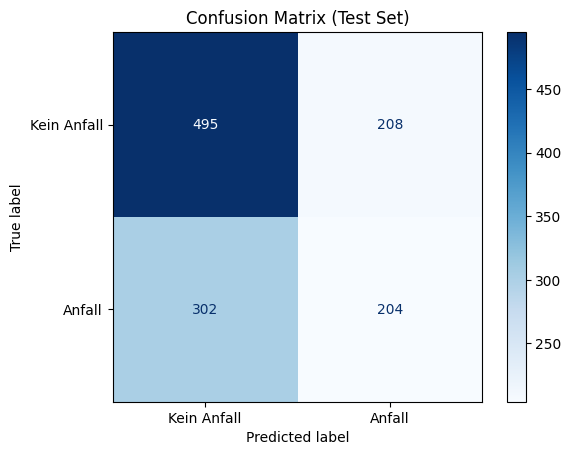

Fold 2
  Test accuracy:  0.43
  Train accuracy: 0.97


<Figure size 600x600 with 0 Axes>

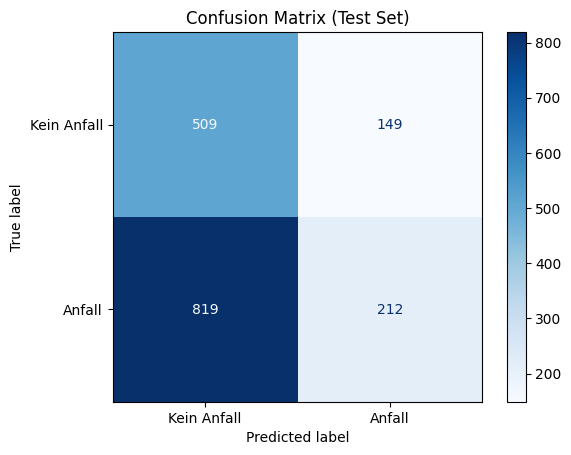

Fold 3
  Test accuracy:  0.56
  Train accuracy: 0.96


<Figure size 600x600 with 0 Axes>

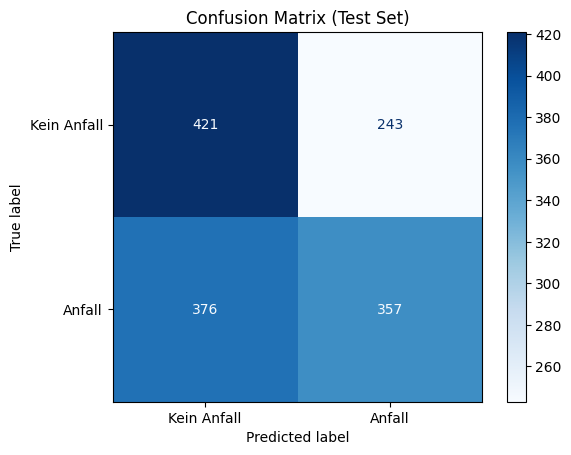

Fold 4
  Test accuracy:  0.54
  Train accuracy: 0.96


<Figure size 600x600 with 0 Axes>

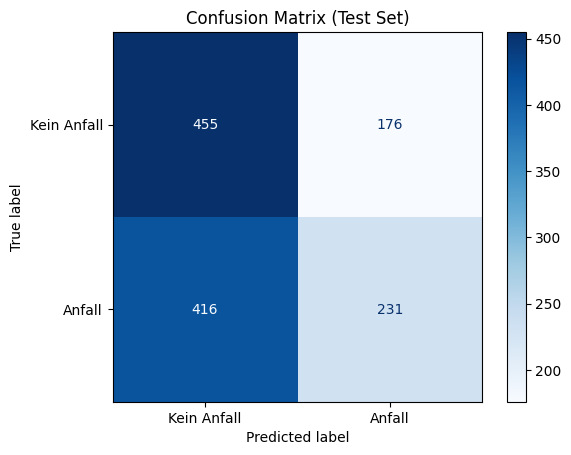

Fold 5
  Test accuracy:  0.59
  Train accuracy: 0.95


<Figure size 600x600 with 0 Axes>

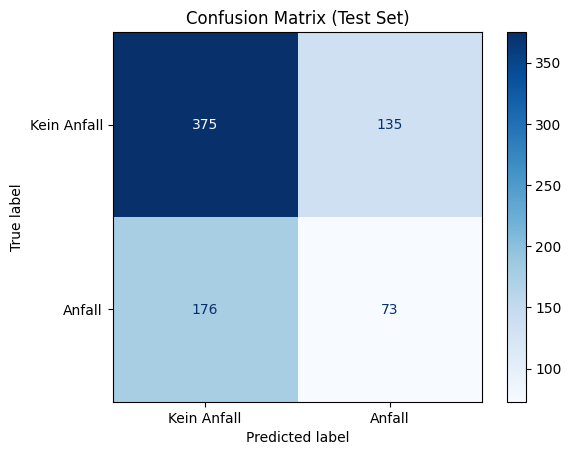

In [7]:
#stratified group split

import random
import importlib
import torch
import os
from torch.utils.data import random_split, DataLoader, ConcatDataset, Subset,TensorDataset
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import torch.nn as nn 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import csv
from collections import defaultdict
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

# Datenordner einladen:
data_folder = "data_test"
file_paths = sorted(glob(os.path.join(data_folder, "*.pt")))

if not os.path.exists(data_folder):
    raise FileNotFoundError("Unterordner nicht gefunden")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Modell instantiieren

train_losses = []
train_accuracies = []
test_accuracies = []
batch_nr = 0
train_dataset_global = []
test_dataset_global =[]

all_x = []
all_y = []
all_id = []

for file_path in file_paths:


    dataset = torch.load(file_path)
    for x, y, gruppe in dataset:

        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
  
        all_x.append(x)
        all_y.append(int(y))
        all_id.append(gruppe)
    
    #print(f"{file_path} loaded")
    batch_nr = batch_nr + 1

print(f"shape x {len(all_x[0])}")
print(f"yshape {all_y[0]}")
print(f"id {all_id[0]}")


# stratified == erhält Klassengewichtung für alle Folds und Groupkfold = keine Überschneidung Patienten

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

metrics = []
all_x_np = np.stack([x.numpy() for x in all_x])  # shape: (N, 11, 5, 5)
all_y_np = np.array(all_y)
all_id_np = np.array(all_id)

# Ausgeglichenen Datensatz erzeugen

df = pd.DataFrame({
    'x': list(all_x_np),  # Jede Zeile ist ein 3D-Array (11,5,5)
    'y': all_y_np,
    'id': all_id_np
})

# Positive und negative Klassen separieren
df_pos = df[df['y'] == 1]
df_neg = df[df['y'] == 0]

df_neg_bal = df_neg.sample(len(df_pos), random_state=42)

df_balanced = pd.concat([df_pos, df_neg_bal]).sample(frac=1, random_state=42) 

print(f"positive samples: {len(df_pos)} von {len(df_balanced)}")

x_balanced = np.stack(df_balanced['x'].values) 
y_balanced = df_balanced['y'].values
id_balanced = df_balanced['id'].values

'''
# Berechnung der Klassengewichte
classes = np.unique(all_y_np)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_y_np)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
'''

for fold, (train_idx, test_idx) in enumerate(cv.split(x_balanced, y_balanced, id_balanced)):
    print(f"Fold {fold+1}")
    X_train, X_test = x_balanced[train_idx], x_balanced[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]


    #Modell instantiieren
    import CNN_model
    importlib.reload(CNN_model)
    model = CNN_model.CNN_EEG(in_channels=11, n_classes=2)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 30


    # Wenn X_train und y_train numpy arrays sind:
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Gleiches für Testdaten:
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for x, y in train_loader:
        print("x NaN:", torch.isnan(x).any())
        print("x Inf:", torch.isinf(x).any())
        print("y NaN:", torch.isnan(y).any())
        print("y Inf:", torch.isinf(y).any())
        print("x stats - min:", x.min().item(), "max:", x.max().item(), "mean:", x.mean().item(), "std:", x.std().item())
        break

    print(f"starting training on {device}")   

    #Training 
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = CNN_model.train_model(model, train_loader, optimizer, loss_fn,device)
        test_acc, y_true, y_pred = CNN_model.evaluate_model(model, test_loader,device)
        #print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
        
    cm = confusion_matrix(y_true, y_pred)
    metrics.append((test_acc,train_acc,y_pred,cm))

    print(f"Metrics last epoch,fold: {fold} test_acc: {test_acc}, train_acc: {train_acc}")
    torch.save(model, f"models_strat/model_{fold}.pth")
print("finished training")

for fold, (test_acc, train_acc, y_pred, cm) in enumerate(metrics):
    print(f"Fold {fold+1}")
    print(f"  Test accuracy:  {test_acc:.2f}")
    print(f"  Train accuracy: {train_acc:.2f}")
                       
    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Anfall", "Anfall"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix (Test Set)")
    plt.grid(False)
    plt.show()




In [3]:
#ausprobieren 12.06, einlesen und trainieren der fertigen Datensätze

import random
import importlib
import torch
import os
from torch.utils.data import random_split, DataLoader, ConcatDataset, Subset
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import torch.nn as nn 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import csv
from collections import defaultdict


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Modell instantiieren
import CNN_model
importlib.reload(CNN_model)
model = CNN_model.CNN_EEG(in_channels=9, n_classes=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4) # weight decay hinzugefügt, dadurch wesentlich besser
num_epochs = 50
train_losses = []
train_accuracies = []
test_accuracies = []

#einlesen der davor abgespeicherten Datensätze
train_dataset_global= torch.load('data_plv/train_dataset.pt')
test_dataset_global = torch.load('data_plv/test_dataset.pt')

train_loader = DataLoader(train_dataset_global, batch_size =32, shuffle = True)
test_loader = DataLoader(test_dataset_global, batch_size =32, shuffle = False)
loss_fn = nn.CrossEntropyLoss()
    
for x, y in train_loader:
    print("x NaN:", torch.isnan(x).any())
    print("x Inf:", torch.isinf(x).any())
    print("y NaN:", torch.isnan(y).any())
    print("y Inf:", torch.isinf(y).any())
    print("x stats - min:", x.min().item(), "max:", x.max().item(), "mean:", x.mean().item(), "std:", x.std().item())
    break

print(f"starting training on {device}")   

#Training 
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = CNN_model.train_model(model, train_loader, optimizer, loss_fn,device)
    test_acc, y_true, y_pred = CNN_model.evaluate_model(model, test_loader,device)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    
train_losses.append(train_loss)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
cm = confusion_matrix(y_true, y_pred)

 
torch.save(model, "trained_cnn_balanced_12_06_full.pth")
print("finished, model saved")

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Anfall", "Anfall"])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

#Trainingsverlauf plotten
epochs = range(1, len(train_losses) + 1)

#Prozess plotten
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

hyperparams = {
    "model": "trained_cnn_balanced_12_06_full.pth", #Händisch anpassen
    "learning_rate": optimizer.param_groups[0]['lr'], 
    "weight_decay": 0.0,
    "loss_function": "CrossEntropyLoss", #muss händisch angepasst werden jenachdem welcher loss verwendet worden ist
    "class_weights": "balanced",  # if using torch weights
    "oversampling": 3.0, #Händisch anpassen, Wert von Zeile 66
    "num_epochs": num_epochs,
    "batch_size": 32,
    "threshold": 0.3,  # if applicable
    "gamma": None,  # set to 2.0 if using FocalLoss
    "notes": "Balanced CE with dynamic weights",
    "f1_score": f1_score(y_true, y_pred, average='binary')
}

os.makedirs("results", exist_ok=True)
file_path = "results/hyperparameters_log.csv"

# Write header only if file does not exist
write_header = not os.path.exists(file_path)

with open(file_path, mode='a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=hyperparams.keys())
    if write_header:
        writer.writeheader()
    writer.writerow(hyperparams)


FileNotFoundError: [Errno 2] No such file or directory: 'data_plv/train_dataset.pt'